In [101]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score

In [102]:
pd.set_option('display.max_columns', 500)

Reading the data

In [103]:
titanic_train = pd.read_csv(r"F:\PGD_UpGrad\Data_Sets\titanic\train.csv")
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [104]:
titanic_train.shape

(891, 12)

In [105]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


#### Data Preparation

##### Missing value treatment

In [106]:
titanic_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [107]:
titanic_train.Cabin.value_counts(dropna = False)

NaN                687
C23 C25 C27          4
B96 B98              4
G6                   4
E101                 3
F33                  3
C22 C26              3
D                    3
F2                   3
C125                 2
E8                   2
B5                   2
B35                  2
C126                 2
B49                  2
E121                 2
C52                  2
B18                  2
B58 B60              2
C124                 2
B28                  2
D36                  2
C93                  2
D33                  2
C92                  2
E24                  2
B57 B59 B63 B66      2
C68                  2
F4                   2
C65                  2
                  ... 
D10 D12              1
C128                 1
A34                  1
C62 C64              1
C50                  1
F38                  1
B102                 1
E38                  1
C86                  1
C104                 1
B101                 1
A23                  1
C91        

In [108]:
titanic_train.Cabin = titanic_train.Cabin.fillna("Unknown_Cabin")

In [109]:
titanic_train.Cabin = titanic_train.Cabin.str[0]

In [110]:
titanic_train.Cabin.value_counts()

U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

In [111]:
titanic_train.isna().sum()/titanic_train.shape[0] *100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin           0.000000
Embarked        0.224467
dtype: float64

In [112]:
titanic_train.Embarked.value_counts(dropna = False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [113]:
titanic_train.Embarked = titanic_train.Embarked.fillna('S')

In [114]:
titanic_train['Title'] = titanic_train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
titanic_train = titanic_train.drop('Name',axis=1)

In [115]:
titanic_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,U,S,Mr
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C,C,Mrs
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,Miss
3,4,1,1,female,35.0,1,0,113803,53.1000,C,S,Mrs
4,5,0,3,male,35.0,0,0,373450,8.0500,U,S,Mr


In [116]:
#let's replace a few titles -> "other" and fix a few titles
titanic_train['Title'] = np.where((titanic_train.Title=='Capt') | (titanic_train.Title=='Countess') | \
                                  (titanic_train.Title=='Don') | (titanic_train.Title=='Dona')| (titanic_train.Title=='Jonkheer') \
                                  | (titanic_train.Title=='Lady') | (titanic_train.Title=='Sir') | (titanic_train.Title=='Major') | \
                                  (titanic_train.Title=='Rev') | (titanic_train.Title=='Col'),'Other',titanic_train.Title)

titanic_train['Title'] = titanic_train['Title'].replace('Ms','Miss')
titanic_train['Title'] = titanic_train['Title'].replace('Mlle','Miss')
titanic_train['Title'] = titanic_train['Title'].replace('Mme','Mrs')

In [117]:
titanic_train.Title.value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Other      16
Dr          7
Name: Title, dtype: int64

For imputing the missing value from the age we need to calculate average age value of title and then impute the average value to the missing one

In [118]:
titanic_train.groupby('Title').Age.mean()

Title
Dr        42.000000
Master     4.574167
Miss      21.845638
Mr        32.368090
Mrs       35.788991
Other     46.875000
Name: Age, dtype: float64

In [119]:
titanic_train["Age"] = np.where((titanic_train.Age.isnull()) & (titanic_train.Title == 'Master'), 5,\
                               np.where((titanic_train.Age.isnull()) & (titanic_train.Title=='Miss'),22,\
                                        np.where((titanic_train.Age.isnull()) & (titanic_train.Title=='Mr'),32,\
                                                 np.where((titanic_train.Age.isnull()) & (titanic_train.Title=='Mrs'),36,\
                                                          np.where((titanic_train.Age.isnull()) & (titanic_train.Title=='Other'),47,\
                                                                   np.where((titanic_train.Age.isnull()) & (titanic_train.Title=='Dr'),42,titanic_train.Age))))))

In [120]:
titanic_train.isnull().sum()/titanic_train.shape[0] *100

PassengerId    0.0
Survived       0.0
Pclass         0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Cabin          0.0
Embarked       0.0
Title          0.0
dtype: float64

In [121]:
titanic_train.shape

(891, 12)

In [122]:
col_list = list(titanic_train.columns)
for col in col_list:
    print(titanic_train[col].value_counts())
    print("-----------------------------")

891    1
293    1
304    1
303    1
302    1
301    1
300    1
299    1
298    1
297    1
296    1
295    1
294    1
292    1
306    1
291    1
290    1
289    1
288    1
287    1
286    1
285    1
284    1
283    1
282    1
281    1
305    1
307    1
279    1
321    1
      ..
561    1
560    1
584    1
585    1
586    1
587    1
610    1
609    1
608    1
607    1
606    1
605    1
604    1
603    1
602    1
601    1
600    1
599    1
598    1
597    1
596    1
595    1
594    1
593    1
592    1
591    1
590    1
589    1
588    1
1      1
Name: PassengerId, Length: 891, dtype: int64
-----------------------------
0    549
1    342
Name: Survived, dtype: int64
-----------------------------
3    491
1    216
2    184
Name: Pclass, dtype: int64
-----------------------------
male      577
female    314
Name: Sex, dtype: int64
-----------------------------
32.00    137
22.00     63
36.00     39
24.00     30
18.00     26
30.00     25
19.00     25
28.00     25
21.00     24
25.00     23
29.

In [123]:
titanic_train = titanic_train.drop("Ticket", axis=1)
titanic_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,1,0,3,male,22.0,1,0,7.2500,U,S,Mr
1,2,1,1,female,38.0,1,0,71.2833,C,C,Mrs
2,3,1,3,female,26.0,0,0,7.9250,U,S,Miss
3,4,1,1,female,35.0,1,0,53.1000,C,S,Mrs
4,5,0,3,male,35.0,0,0,8.0500,U,S,Mr


### Dummy variable

In [124]:
dummy_1 = pd.get_dummies(titanic_train["Embarked"], prefix= "Embarked", drop_first=True)
dummy_2 = pd.get_dummies(titanic_train["Sex"], drop_first=False)
Pclass = pd.get_dummies(titanic_train["Pclass"], prefix= "Pclass")
siblings = pd.get_dummies(titanic_train["SibSp"], prefix= "SibSp")
Parch = pd.get_dummies(titanic_train["Parch"], prefix= "Parch")
cabin = pd.get_dummies(titanic_train["Cabin"], prefix= "Cabin")
Title = pd.get_dummies(titanic_train["Title"], prefix= "Title")

In [125]:
titanic_train = pd.concat([titanic_train, dummy_1, dummy_2, Pclass, siblings, Parch], axis=1)
titanic_train = titanic_train.drop(["Embarked","PassengerId", "Sex", "Pclass", "SibSp", "Parch", "Cabin", "Title"], axis=1)
titanic_train.head()

,Survived,Age,Fare,Embarked_Q,Embarked_S,female,male,Pclass_1,Pclass_2,Pclass_3,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,0,22.0,7.2500,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,1,38.0,71.2833,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,1,26.0,7.9250,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1,35.0,53.1000,0,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,0,35.0,8.0500,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0


### Feature Scaling

In [126]:
scalar = MinMaxScaler()
scale_var = ["Age", "Fare"]
titanic_train[scale_var] = scalar.fit_transform(titanic_train[scale_var])
titanic_train.head()

,Survived,Age,Fare,Embarked_Q,Embarked_S,female,male,Pclass_1,Pclass_2,Pclass_3,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,0,0.271174,0.014151,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,1,0.472229,0.139136,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,1,0.321438,0.015469,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1,0.434531,0.103644,0,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0.434531,0.015713,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [127]:
y_train = titanic_train.pop("Survived")
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [128]:
X_train = titanic_train
X_train.head()

,Age,Fare,Embarked_Q,Embarked_S,female,male,Pclass_1,Pclass_2,Pclass_3,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,0.271174,0.014151,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,0.472229,0.139136,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,0.321438,0.015469,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0.434531,0.103644,0,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,0.434531,0.015713,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0


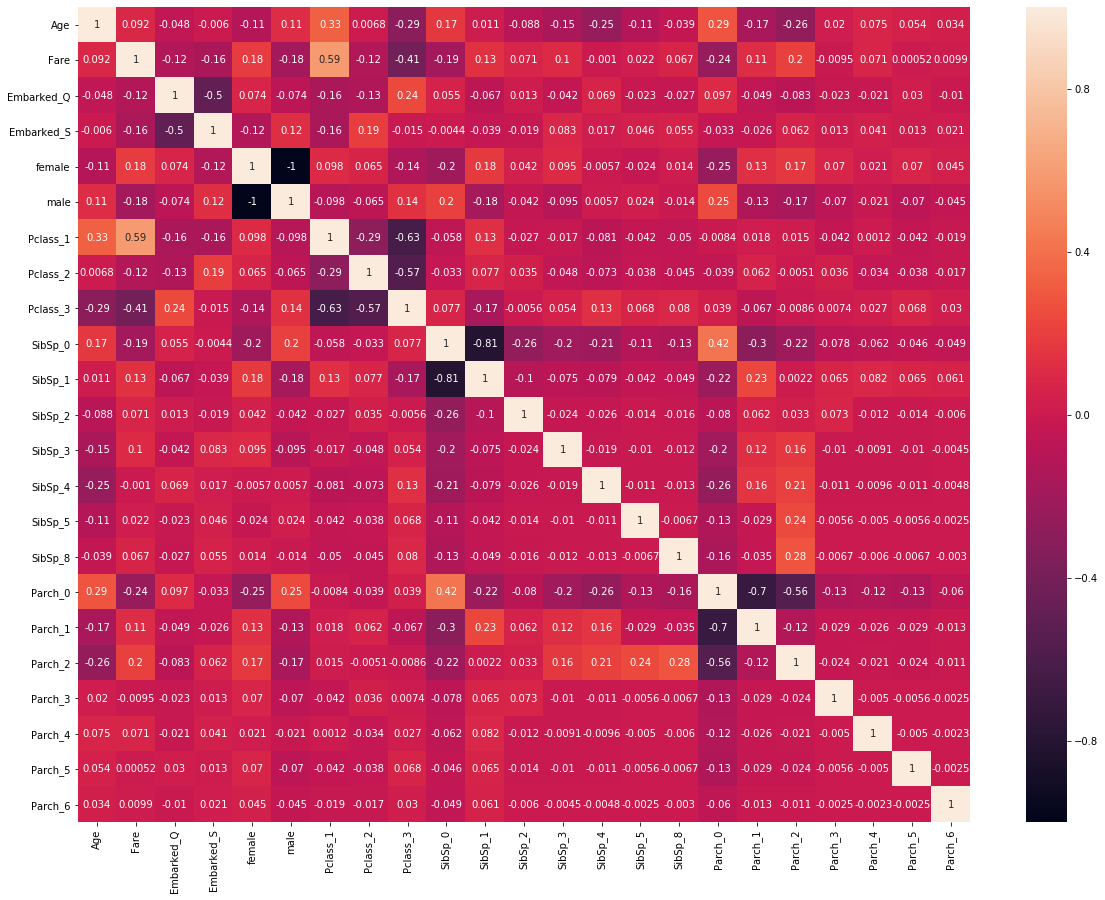

In [129]:
plt.figure(figsize=(20, 15))
sns.heatmap(X_train.corr(), annot=True)
plt.show()

### Model Building

In [130]:
logreg = LogisticRegression()

In [131]:
rfe = RFE(logreg, 12)
rfe = rfe.fit(X_train, y_train)

In [132]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Age', True, 1),
 ('Fare', True, 1),
 ('Embarked_Q', False, 12),
 ('Embarked_S', False, 5),
 ('female', True, 1),
 ('male', True, 1),
 ('Pclass_1', True, 1),
 ('Pclass_2', False, 11),
 ('Pclass_3', True, 1),
 ('SibSp_0', True, 1),
 ('SibSp_1', True, 1),
 ('SibSp_2', True, 1),
 ('SibSp_3', True, 1),
 ('SibSp_4', False, 7),
 ('SibSp_5', False, 3),
 ('SibSp_8', True, 1),
 ('Parch_0', False, 9),
 ('Parch_1', False, 6),
 ('Parch_2', False, 10),
 ('Parch_3', False, 8),
 ('Parch_4', True, 1),
 ('Parch_5', False, 2),
 ('Parch_6', False, 4)]

In [133]:
col_support = X_train.columns[rfe.support_]
col_support

Index(['Age', 'Fare', 'female', 'male', 'Pclass_1', 'Pclass_3', 'SibSp_0',
       'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_8', 'Parch_4'],
      dtype='object')

In [134]:
X_train_sm = sm.add_constant(X_train[col_support])
logmodel1 = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial()).fit()
logmodel1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      879
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -384.89
Date:                Sun, 24 Nov 2019   Deviance:                       769.78
Time:                        17:48:31   Pearson chi2:                     942.
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4375      0.488     -0.896      0.370      -1.395       0.520
Age           -3.4362      0.643     -5.342      0.000      -4.697      -2.175
Fare           1.4112      1.218      1.158      0.247      -0.976       3.799
female         1.1188      0.262      4.264      0.000       0.605       1.633
male          -1.5563      0.264     -5.895      0.000      -2.074      -1.039
Pclass_1       1.1109      0.297      3.745      0.000       0.530       1.692
Pclass_3      -1.0493      0.232     -4.522      0.000      -1.504      -0.595
SibSp_0        1.9857      0.716      2.774      0.006       0.583       3.389
SibSp_1        2.1096      0.727      2.904      0.004       0.686       3.534
SibSp_2        1.7453      0.859      2.033      0.042       0.063       3.428
SibSp_3       -0.3283      0.964     -0.341      0.733      -2.218       1.561
SibSp_8      -20.1197   1.36e+04     -0.001      0.999   -2.67e+04    2.67e+04
Parch_4      -22.1891   2.31e+04     -0.001      0.999   -4.53e+04    4.53e+04
==============================================================================
"""

Most of the feature having P values more than 0.05 we have to drop those values but first calculate the vif

In [135]:
col_support = col_support.drop(["SibSp_8"])

In [136]:
X_train_sm = sm.add_constant(X_train[col_support])
logmodel2 = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial()).fit()
logmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      880
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -385.70
Date:                Sun, 24 Nov 2019   Deviance:                       771.40
Time:                        17:48:31   Pearson chi2:                     954.
No. Iterations:                    30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6433      0.475     -1.354      0.176      -1.574       0.288
Age           -3.4824      0.642     -5.420      0.000      -4.742      -2.223
Fare           1.3381      1.206      1.109      0.267      -1.026       3.703
female         1.0149      0.255      3.977      0.000       0.515       1.515
male          -1.6582      0.259     -6.402      0.000      -2.166      -1.151
Pclass_1       1.1233      0.296      3.792      0.000       0.543       1.704
Pclass_3      -1.0526      0.232     -4.536      0.000      -1.507      -0.598
SibSp_0        2.3134      0.687      3.369      0.001       0.967       3.659
SibSp_1        2.4384      0.697      3.498      0.000       1.072       3.805
SibSp_2        2.0726      0.835      2.483      0.013       0.437       3.708
SibSp_3        0.0009      0.941      0.001      0.999      -1.843       1.845
Parch_4      -30.7454   1.68e+06  -1.83e-05      1.000   -3.29e+06    3.29e+06
==============================================================================
"""

In [137]:
col_support = col_support.drop(["Parch_4"])

In [138]:
X_train_sm = sm.add_constant(X_train[col_support])
logmodel3 = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial()).fit()
logmodel3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      881
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -387.66
Date:                Sun, 24 Nov 2019   Deviance:                       775.32
Time:                        17:48:31   Pearson chi2:                     960.
No. Iterations:                    29                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6036      0.474     -1.274      0.203      -1.532       0.325
Age           -3.5851      0.638     -5.617      0.000      -4.836      -2.334
Fare           1.1515      1.160      0.993      0.321      -1.122       3.425
female         1.0294      0.255      4.042      0.000       0.530       1.528
male          -1.6329      0.258     -6.325      0.000      -2.139      -1.127
Pclass_1       1.1439      0.295      3.880      0.000       0.566       1.722
Pclass_3      -1.0805      0.231     -4.668      0.000      -1.534      -0.627
SibSp_0        2.3012      0.686      3.352      0.001       0.956       3.647
SibSp_1        2.4107      0.697      3.460      0.001       1.045       3.776
SibSp_2        2.0679      0.835      2.477      0.013       0.432       3.704
SibSp_3        0.0087      0.939      0.009      0.993      -1.832       1.849
==============================================================================
"""

In [139]:
vif = pd.DataFrame()
vif["Features"] = col_support
vif["VIF"] = [variance_inflation_factor(X_train[col_support].values, i) for i in range(X_train[col_support].shape[1])]
vif["VIF"] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
3,male,26.52
2,female,14.62
6,SibSp_0,7.50
7,SibSp_1,6.73
4,Pclass_1,2.26
8,SibSp_2,1.92
5,Pclass_3,1.74
1,Fare,1.68
9,SibSp_3,1.52
0,Age,1.29


In [140]:
col_support = col_support.drop(["SibSp_3"])

In [141]:
X_train_sm = sm.add_constant(X_train[col_support])
logmodel4 = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial()).fit()
logmodel4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      882
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -387.66
Date:                Sun, 24 Nov 2019   Deviance:                       775.32
Time:                        17:48:31   Pearson chi2:                     960.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6007      0.364     -1.651      0.099      -1.314       0.112
Age           -3.5850      0.638     -5.617      0.000      -4.836      -2.334
Fare           1.1522      1.158      0.995      0.320      -1.118       3.422
female         1.0308      0.202      5.099      0.000       0.635       1.427
male          -1.6316      0.211     -7.732      0.000      -2.045      -1.218
Pclass_1       1.1439      0.295      3.880      0.000       0.566       1.722
Pclass_3      -1.0806      0.231     -4.672      0.000      -1.534      -0.627
SibSp_0        2.2970      0.513      4.474      0.000       1.291       3.303
SibSp_1        2.4065      0.524      4.589      0.000       1.379       3.434
SibSp_2        2.0636      0.697      2.959      0.003       0.697       3.431
==============================================================================
"""

In [142]:
col_support = col_support.drop("Fare")

In [143]:
X_train_sm = sm.add_constant(X_train[col_support])
logmodel5 = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial()).fit()
logmodel5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      883
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -388.18
Date:                Sun, 24 Nov 2019   Deviance:                       776.37
Time:                        17:48:31   Pearson chi2:                     955.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5067      0.348     -1.455      0.146      -1.189       0.176
Age           -3.6222      0.637     -5.690      0.000      -4.870      -2.374
female         1.0855      0.193      5.619      0.000       0.707       1.464
male          -1.5922      0.206     -7.733      0.000      -1.996      -1.189
Pclass_1       1.2738      0.265      4.800      0.000       0.754       1.794
Pclass_3      -1.1037      0.231     -4.787      0.000      -1.556      -0.652
SibSp_0        2.2086      0.500      4.414      0.000       1.228       3.189
SibSp_1        2.3397      0.515      4.542      0.000       1.330       3.349
SibSp_2        2.0246      0.694      2.918      0.004       0.665       3.384
==============================================================================
"""

In [144]:
vif = pd.DataFrame()
vif["Features"] = col_support
vif["VIF"] = [variance_inflation_factor(X_train[col_support].values, i) for i in range(X_train[col_support].shape[1])]
vif["VIF"] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
2,male,18.82
1,female,9.81
5,SibSp_0,5.05
6,SibSp_1,4.69
3,Pclass_1,1.73
4,Pclass_3,1.73
7,SibSp_2,1.60
0,Age,1.28


In [145]:
col_support = col_support.drop(["male"])

In [146]:
X_train_sm = sm.add_constant(X_train[col_support])
logmodel6 = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial()).fit()
logmodel6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      883
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -388.18
Date:                Sun, 24 Nov 2019   Deviance:                       776.37
Time:                        17:48:32   Pearson chi2:                     955.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0989      0.539     -3.897      0.000      -3.154      -1.043
Age           -3.6222      0.637     -5.690      0.000      -4.870      -2.374
female         2.6777      0.195     13.711      0.000       2.295       3.060
Pclass_1       1.2738      0.265      4.800      0.000       0.754       1.794
Pclass_3      -1.1037      0.231     -4.787      0.000      -1.556      -0.652
SibSp_0        2.2086      0.500      4.414      0.000       1.228       3.189
SibSp_1        2.3397      0.515      4.542      0.000       1.330       3.349
SibSp_2        2.0246      0.694      2.918      0.004       0.665       3.384
==============================================================================
"""

In [148]:
vif = pd.DataFrame()
vif["Features"] = col_support
vif["VIF"] = [variance_inflation_factor(X_train[col_support].values, i) for i in range(X_train[col_support].shape[1])]
vif["VIF"] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
0,Age,7.03
4,SibSp_0,7.01
5,SibSp_1,2.97
3,Pclass_3,2.86
2,Pclass_1,2.15
1,female,1.56
6,SibSp_2,1.20


In [149]:
col_support = col_support.drop(["Age"])

In [150]:
X_train_sm = sm.add_constant(X_train[col_support])
logmodel6 = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial()).fit()
logmodel6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      884
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -405.92
Date:                Sun, 24 Nov 2019   Deviance:                       811.84
Time:                        17:48:38   Pearson chi2:                     918.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8577      0.525     -5.441      0.000      -3.887      -1.828
female         2.7105      0.191     14.185      0.000       2.336       3.085
Pclass_1       0.8644      0.247      3.495      0.000       0.380       1.349
Pclass_3      -0.9380      0.225     -4.178      0.000      -1.378      -0.498
SibSp_0        1.5968      0.485      3.294      0.001       0.647       2.547
SibSp_1        1.7883      0.503      3.558      0.000       0.803       2.773
SibSp_2        1.7677      0.667      2.650      0.008       0.460       3.075
==============================================================================
"""

In [151]:
vif = pd.DataFrame()
vif["Features"] = col_support
vif["VIF"] = [variance_inflation_factor(X_train[col_support].values, i) for i in range(X_train[col_support].shape[1])]
vif["VIF"] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
vif

,Features,VIF
1,Pclass_1,1.96
4,SibSp_1,1.84
2,Pclass_3,1.37
5,SibSp_2,1.10
3,SibSp_0,0.51
0,female,0.29


In [152]:
y_train_pred = logmodel6.predict(X_train_sm)

In [153]:
y_train_pred[:10].values

array([0.11843241, 0.9245303 , 0.6251869 , 0.9245303 , 0.09984953,
       0.09984953, 0.40215248, 0.02197342, 0.6251869 , 0.83769212])

In [154]:
y_train_pred_final = pd.DataFrame({'Survived': y_train.values, 'survived_prob':y_train_pred})
y_train_pred_final.head()

,Survived,survived_prob
0,0,0.118432
1,1,0.924530
2,1,0.625187
3,1,0.924530
4,0,0.099850


In [155]:
y_train_pred_final['Predicted_survived'] = y_train_pred_final.survived_prob.map(lambda x : 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Survived,survived_prob,Predicted_survived
0,0,0.118432,0
1,1,0.924530,1
2,1,0.625187,1
3,1,0.924530,1
4,0,0.099850,0


### Ploting ROC curve and calculate the cutoff

In [156]:
def draw_roc_curve(actual, prob):
    fpr, tpr, threshold = metrics.roc_curve(actual, prob, drop_intermediate=False)
    auc_score = metrics.roc_auc_score(actual, prob)
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [157]:
fpr, tpr, thresholds = metrics.roc_curve(y_train_pred_final.Survived, y_train_pred_final.Predicted_survived, drop_intermediate = False )

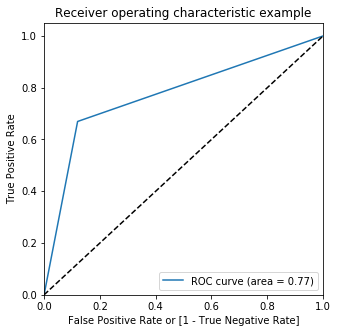

In [158]:
draw_roc_curve(y_train_pred_final.Survived, y_train_pred_final.Predicted_survived)

In [159]:
# Lets create columns with different cutoff points
numbers = [x/10 for x in range(10)]

for i in numbers:
    y_train_pred_final[i] = y_train_pred_final.survived_prob.map(lambda x : 1 if x > i else 0)
y_train_pred_final.head()

,Survived,survived_prob,Predicted_survived,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.118432,0,1,1,0,0,0,0,0,0,0,0
1,1,0.924530,1,1,1,1,1,1,1,1,1,1,1
2,1,0.625187,1,1,1,1,1,1,1,1,0,0,0
3,1,0.924530,1,1,1,1,1,1,1,1,1,1,1
4,0,0.099850,0,1,0,0,0,0,0,0,0,0,0


In [160]:
# Now calculate accuracy, sensitivity and specificity for variouse probability cuttoff
cutoff_df = pd.DataFrame(columns=['Probability', 'Accuracy', 'Sensitivity', 'Specificity'])
from sklearn.metrics import confusion_matrix

for i in numbers:
    conf_mat = metrics.confusion_matrix(y_train_pred_final.Survived, y_train_pred_final[i])
    total = sum(sum(conf_mat))
    accuracy = (conf_mat[0,0]+conf_mat[1,1])/total
    
    sensitivity = conf_mat[1,1]/(conf_mat[1,0]+conf_mat[1,1])
    specificity = conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
    cutoff_df.loc[i] = [i, accuracy, sensitivity, specificity]
cutoff_df

,Probability,Accuracy,Sensitivity,Specificity
0.0,0.0,0.383838,1.000000,0.000000
0.1,0.1,0.632997,0.894737,0.469945
0.2,0.2,0.668911,0.862573,0.548270
0.3,0.3,0.765432,0.804094,0.741348
0.4,0.4,0.765432,0.804094,0.741348
0.5,0.5,0.799102,0.669591,0.879781
0.6,0.6,0.799102,0.669591,0.879781
0.7,0.7,0.783389,0.461988,0.983607
0.8,0.8,0.783389,0.461988,0.983607
0.9,0.9,0.712682,0.260234,0.994536


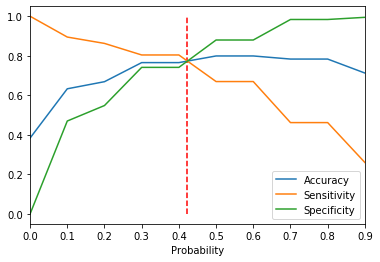

In [164]:
# lets plot the accuracy, sensitivity and specificity over the probability
cutoff_df.plot.line(x = "Probability", y=['Accuracy', 'Sensitivity', 'Specificity'])
plt.vlines(x=0.423, ymax=1, ymin=0, colors='r', linestyles='--')
plt.show()

In [165]:
y_train_pred_final["Predicted_survived"] = y_train_pred_final.survived_prob.map(lambda x: 1 if x > 0.423 else 0)
y_train_pred_final.head()

,Survived,survived_prob,Predicted_survived,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.118432,0,1,1,0,0,0,0,0,0,0,0
1,1,0.924530,1,1,1,1,1,1,1,1,1,1,1
2,1,0.625187,1,1,1,1,1,1,1,1,0,0,0
3,1,0.924530,1,1,1,1,1,1,1,1,1,1,1
4,0,0.099850,0,1,0,0,0,0,0,0,0,0,0


In [166]:
metrics.accuracy_score(y_train_pred_final.Survived, y_train_pred_final.Predicted_survived)

0.7991021324354658

In [167]:
confusion = metrics.confusion_matrix(y_train_pred_final.Survived, y_train_pred_final.Predicted_survived)
confusion

array([[466,  83],
       [ 96, 246]], dtype=int64)

In [168]:
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]
TP = confusion[1,1]

In [169]:
# calculate the sensitivity
TP/(TP+FN)

0.7192982456140351

In [170]:
# calculate the specificity
TN/(FP+TN)

0.848816029143898

In [171]:
# calcuate false posititve rate
FP/(TN+FP)

0.151183970856102

In [172]:
#positive predicted value
TP / (TP+FP)

0.7477203647416414

In [173]:
# negative predicted value
TN/(TN+FN)

0.8291814946619217

In [174]:
precision_score(y_train_pred_final.Survived, y_train_pred_final.Predicted_survived)

0.7477203647416414

In [175]:
recall_score(y_train_pred_final.Survived, y_train_pred_final.Predicted_survived)

0.7192982456140351

In [176]:
#False negative rate
FN/(TP+FN)

0.2807017543859649

### Making prediction on Test set

In [177]:
titanic_test = pd.read_csv(r"F:\PGD_UpGrad\Data_Sets\titanic\test.csv")
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [178]:
servived_test = pd.read_csv(r"F:\PGD_UpGrad\Data_Sets\titanic\gender_submission.csv")
servived_test.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [179]:
titanic_test = pd.merge(titanic_test, servived_test, how='inner', on='PassengerId')
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [180]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
Survived       418 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 42.5+ KB


In [181]:
titanic_test.Cabin = titanic_test.Cabin.fillna("Unknown_Cabin")
titanic_test.Cabin = titanic_test.Cabin.str[0]
titanic_test.Cabin.value_counts()

U    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Cabin, dtype: int64

In [182]:
round(titanic_test.isnull().sum()/titanic_test.shape[0]*100, 2)

PassengerId     0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            20.57
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.24
Cabin           0.00
Embarked        0.00
Survived        0.00
dtype: float64

In [183]:
titanic_test['Title'] = titanic_test.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
titanic_test = titanic_test.drop('Name',axis=1)

In [184]:
titanic_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Title
0,892,3,male,34.5,0,0,330911,7.8292,U,Q,0,Mr
1,893,3,female,47.0,1,0,363272,7.0000,U,S,1,Mrs
2,894,2,male,62.0,0,0,240276,9.6875,U,Q,0,Mr
3,895,3,male,27.0,0,0,315154,8.6625,U,S,0,Mr
4,896,3,female,22.0,1,1,3101298,12.2875,U,S,1,Mrs


In [185]:
#let's replace a few titles -> "other" and fix a few titles
titanic_test['Title'] = np.where((titanic_test.Title=='Capt') | (titanic_test.Title=='Countess') | \
                                  (titanic_test.Title=='Don') | (titanic_test.Title=='Dona')| (titanic_test.Title=='Jonkheer') \
                                  | (titanic_test.Title=='Lady') | (titanic_test.Title=='Sir') | (titanic_test.Title=='Major') | \
                                  (titanic_test.Title=='Rev') | (titanic_test.Title=='Col'),'Other',titanic_test.Title)

titanic_test['Title'] = titanic_test['Title'].replace('Ms','Miss')
titanic_test['Title'] = titanic_test['Title'].replace('Mlle','Miss')
titanic_test['Title'] = titanic_test['Title'].replace('Mme','Mrs')

In [186]:
titanic_test.groupby('Title').Age.mean()

Title
Dr        53.000000
Master     7.406471
Miss      21.774844
Mr        32.000000
Mrs       38.903226
Other     42.000000
Name: Age, dtype: float64

In [187]:
titanic_test["Age"] = np.where((titanic_test.Age.isnull()) & (titanic_test.Title == 'Master'), 7,\
                               np.where((titanic_test.Age.isnull()) & (titanic_test.Title=='Miss'),22,\
                                        np.where((titanic_test.Age.isnull()) & (titanic_test.Title=='Mr'),32,\
                                                 np.where((titanic_test.Age.isnull()) & (titanic_test.Title=='Mrs'),39,\
                                                          np.where((titanic_test.Age.isnull()) & (titanic_test.Title=='Other'),42,\
                                                                   np.where((titanic_test.Age.isnull()) & (titanic_test.Title=='Dr'),53,titanic_test.Age))))))

In [188]:
round(titanic_test.isnull().sum()/titanic_test.shape[0]*100, 2)

PassengerId    0.00
Pclass         0.00
Sex            0.00
Age            0.00
SibSp          0.00
Parch          0.00
Ticket         0.00
Fare           0.24
Cabin          0.00
Embarked       0.00
Survived       0.00
Title          0.00
dtype: float64

In [190]:
titanic_test.Fare = titanic_test.Fare.fillna(0)

In [191]:
round(titanic_test.isnull().sum()/titanic_test.shape[0]*100, 2)

PassengerId    0.0
Pclass         0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Cabin          0.0
Embarked       0.0
Survived       0.0
Title          0.0
dtype: float64

In [192]:
PassengerId = titanic_test.PassengerId

In [193]:
dummy_1 = pd.get_dummies(titanic_test["Embarked"], prefix= "Embarked", drop_first=True)
dummy_2 = pd.get_dummies(titanic_test["Sex"], drop_first=False)
Pclass = pd.get_dummies(titanic_test["Pclass"], prefix= "Pclass")
siblings = pd.get_dummies(titanic_test["SibSp"], prefix= "SibSp")
Parch = pd.get_dummies(titanic_test["Parch"], prefix= "Parch")
cabin = pd.get_dummies(titanic_test["Cabin"], prefix= "Cabin")
Title = pd.get_dummies(titanic_test["Title"], prefix= "Title")

In [194]:
titanic_test = pd.concat([titanic_test, dummy_1, dummy_2, Pclass, siblings, Parch], axis=1)
titanic_test = titanic_test.drop(["Embarked","PassengerId", "Sex", "Pclass", "SibSp", "Parch", "Cabin", "Title"], axis=1)
titanic_test.head()

,Age,Ticket,Fare,Survived,Embarked_Q,Embarked_S,female,male,Pclass_1,Pclass_2,Pclass_3,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9
0,34.5,330911,7.8292,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,47.0,363272,7.0000,1,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,62.0,240276,9.6875,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,27.0,315154,8.6625,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,22.0,3101298,12.2875,1,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [195]:
titanic_test = titanic_test.drop(["Ticket"], axis=1)

In [196]:
test_scale_var = ["Age", "Fare"]
titanic_test[test_scale_var] = scalar.transform(titanic_test[test_scale_var])

In [197]:
X_test = titanic_test[col_support]
X_test.head()

,female,Pclass_1,Pclass_3,SibSp_0,SibSp_1,SibSp_2
0,0,0,1,1,0,0
1,1,0,1,0,1,0
2,0,0,0,1,0,0
3,0,0,1,1,0,0
4,1,0,1,0,1,0


In [198]:
X_test_sm = sm.add_constant(X_test)

In [199]:
y_test_pred = logmodel6.predict(X_test_sm)

In [200]:
y_test_pred[:10]

0    0.099850
1    0.668888
2    0.220818
3    0.099850
4    0.668888
5    0.099850
6    0.625187
7    0.255524
8    0.625187
9    0.116293
dtype: float64

In [201]:
y_test_pred_final = pd.DataFrame({"PassengerId":PassengerId ,"Survived":titanic_test.Survived, "Probability_survived": y_test_pred})
y_test_pred_final.head()

,PassengerId,Survived,Probability_survived
0,892,0,0.099850
1,893,1,0.668888
2,894,0,0.220818
3,895,0,0.099850
4,896,1,0.668888


In [202]:
y_test_pred_final["Pred_Survived"] = y_test_pred_final.Probability_survived.map(lambda x: 1 if x > 0.423 else 0)
y_test_pred_final.head()

,PassengerId,Survived,Probability_survived,Pred_Survived
0,892,0,0.099850,0
1,893,1,0.668888,1
2,894,0,0.220818,0
3,895,0,0.099850,0
4,896,1,0.668888,1


In [203]:
metrics.accuracy_score(y_test_pred_final.Survived, y_test_pred_final.Pred_Survived)

0.9401913875598086

In [204]:
confusion = metrics.confusion_matrix(y_test_pred_final.Survived, y_test_pred_final.Pred_Survived)
confusion

array([[244,  22],
       [  3, 149]], dtype=int64)

In [205]:
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]
TP = confusion[1,1]

In [206]:
# calculate the sensitivity
TP/(TP+FN)

0.9802631578947368

In [207]:
# calculate the specificity
TN/(FP+TN)

0.9172932330827067

In [208]:
# calcuate false posititve rate
FP/(TN+FP)

0.08270676691729323

In [209]:
#positive predicted value
TP / (TP+FP)

0.8713450292397661

In [210]:
# negative predicted value
TN/(TN+FN)

0.9878542510121457

In [211]:
precision_score(y_test_pred_final.Survived, y_test_pred_final.Pred_Survived)

0.8713450292397661

In [212]:
recall_score(y_test_pred_final.Survived, y_test_pred_final.Pred_Survived)

0.9802631578947368

In [213]:
y_test_pred_final.shape

(418, 4)

In [217]:
submission = y_test_pred_final[["PassengerId", "Pred_Survived"]]

In [219]:
file_name = "F:\\PGD_UpGrad\\Machine_Learning_1\\Logistic Regression\\Titanic\\titanic_predict_submission.csv"
submission.to_csv(file_name, index = None, header=True)